In [2]:
# Importing all the libraries that would be required later on in the project
import os
import re
import time
import enum

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
# Creating directories' path to save model related stuffs
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries') # This is the location where final trained models will be saved
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints') # Intermediate training models will be saved in this location
DATA_DIR_PATH    = os.path.join(os.getcwd(), 'data') # input ans GAN generated data will be stored in this location
DEBUG_IMAGERY_PATH = os.path.join(DATA_DIR_PATH, 'debug_imagery')

MNIST_IMG_SIZE = 28 # MNIST images would've 28x28 resolution

## Exploring the data - Become One With Your Data!

In this section, we will try to answer questions like below:

1. How many images do I have?
2. What's the shape of the images?
3. How images look like?

Dataset size: 60000 images
Image shape: torch.Size([1, 28, 28])


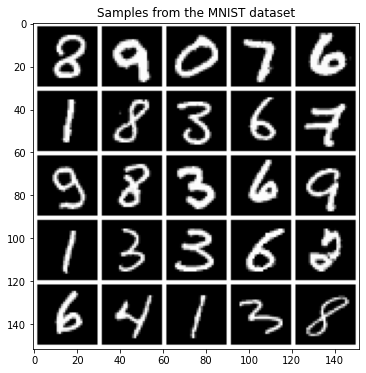

In [5]:
batch_size = 128

# Images are usually in the range [0., 1.] or [0, 255] range. Normalize transforms will bring the range into [-1, 1] range.
# This trick makes the machine model learn well about the dataset and it being a trick was figured out experimentally without
# any theoretical arguments to it.
# More tricks could be found here: https://github.com/soumith/ganhacks
# More information about transforms.Normalize() could be found here: https://discuss.pytorch.org/t/understanding-transform-normalize/21730/19
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])



# MNIST is a "Hello World" dataset for computer vision hence it is included in PyTorch
# It will be downloaded first time and stored in DATA_DIR_PATH
# the "transform" will be applied to every image
mnist_dataset = datasets.MNIST(root=DATA_DIR_PATH, train=True, download=True, transform=transform)


# Defining dataloader class which reads the dataset and provides the dataset in batches to the model
mnist_data_loader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle=True, drop_last=True)

# Q1: How many images are present in dataset?
print(f'Dataset size: {len(mnist_dataset)} images')

num_imgs_to_visualize = 25 # number of images to display
batch = next(iter(mnist_data_loader)) # accessing the first batch from the dataset
img_batch = batch[0] # extracting only images and ignoring the labels (i.e. batch[1])
img_batch_subset = img_batch[:num_imgs_to_visualize]


# Q2: What's the shape of the image?
# format is (B, C, H, W); B -  batch_size or number of images in a batch, C - number of channels, H - height, W - width
print(f"Image shape: {img_batch_subset.shape[1:]}") # ignored shape[0] - number of imgs in batch


# Q3: How do images look like?
# Creating a 5x5 grid of images, normalizing will bring images from [-1, 1] range back into [0,1] for display
# pad_value is 1. (white) because it's 0. (black) by default but since the backgroud is also black
grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True, pad_value=1.)
grid = np.moveaxis(grid.numpy(), 0, 2)
plt.figure(figsize=(6,6))
plt.title("Samples from the MNIST dataset")
plt.imshow(grid)
plt.show()

## Understanding the model

Let's define the generator and discriminator networks.

The original paper used the `maxout` activation and dropout for regularization.

Whereas, here `LeakyRelu` and `batch normalization` is being used which came after original paper was published.

In [8]:
# Size of the generator's input vector. Generator will eventually learn how to map these into meaningful images!
LATENT_SPACE_DIM = 100

# Following function will produce a batch of vectors for generator's input of size LATENT_SPACE_DIM
def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)


# Defining the neural network layers with this function - It's an interesting way to define the neural network's layers
def vanilla_block(in_feat, out_feat, normalize=True, activation=None):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat))
    # 0.2 was used in DCGAN, hence it is used here
    layers.append(nn.LeakyReLU(0.2) if activation is None else activation)
    return layers


class GeneratorNet(torch.nn.Module):
    """
        A simple 4-layer MLP generative neural network.
        
        Be default it works for MNIST size images (28 x 28).
        
        There are many ways to construct generator to work on MNIST. Even without normalization layers, it will work ok.
        Even with 5 layers it will work ok, etc.
        
        It's generally an open research question on how to evaluate GANs i.e. quantify that "ok" statement.
        
        People tried to automate the task using IS, etc. but so far it always ends up with some of visual inspection (human in the loop)
    """
    
    def __init__(self, img_shape = (MNIST_IMG_SIZE, MNIST_IMG_SIZE)): # MNIST_IMG_SIZE = 28
        super().__init__()
        self.generated_img_shape = img_shape
        num_neurons_per_layer    = [LATENT_SPACE_DIM, 256, 512, 1024, img_shape[0]*img_shape[1]]
        
        # The layers are just linear layers followed by LeakyReLU and batch normalization.
        # The last layer excludes batch normalization and TanH is added to map images in [-1, 1] range
        self.net = nn.Sequential(
            *vanilla_block(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            *vanilla_block(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            *vanilla_block(num_neurons_per_layer[2], num_neurons_per_layer[3]),
            *vanilla_block(num_neurons_per_layer[3], num_neurons_per_layer[4], normalize=False, activation=nn.Tanh())
        )
        
    def forward(self, latent_vector_batch):
        img_batch_flattened = self.net(latent_vector_batch)
        # unflattening using view into (N, 1, 28, 28) shape for MNIST
        return img_batch_flattened.view(img_batch_flattened.shape[0], 1, *self.generated_img_shape)
    

class DiscriminatorNet(torch.nn.Module):
    """
        Simple 3-layer MLP discriminative neural network. It should output probability 1 for real images and 0 for fake images
    """
    
    def __init__(self, img_shape=(MNIST_IMG_SIZE, MNIST_IMG_SIZE)):
        super().__init__()
        num_neurons_per_layer = [img_shape[0]*img_shape[1], 512, 256, 1]
        
        # Last layer is Sigmoid function - basically the goal of the discriminator is to output 1.
        # for real images and 0. for fake images and sigmoid is clamped between 0 and 1
        self.net = nn.Sequential(
            *vanilla_block(num_neurons_per_layer[0], num_neurons_per_layer[1], normalize=False),
            *vanilla_block(num_neurons_per_layer[1], num_neurons_per_layer[2], normalize=False),
            *vanilla_block(num_neurons_per_layer[2], num_neurons_per_layer[3], normalize=False, activation=nn.Sigmoid())
        )
        
    def forward(self, img_batch):
        img_batch_flattened = img_batch.view(img_batch.shape[0], -1) # flatten from (N,1,H,W) into (N, HxW)
        return self.net(img_batch_flattened)

## GAN Training

The hardest part of the GAN is to train them.

Let's start with understanding the loss function. The loss function used is `BCE (Binary Cross Entropy)`. Why?

If real images were given as input, the discriminator should output 1 i.e. it is 100% sure it is a real image
The further away it is from 1 and closer to 0, the more discriminator should be penalized, as it is making wrong prediction.
So loss should like this: `-log(x)`

![](cross_entropy_loss.png)

BCE loss basically becomes `-log(x)` when its target (true) label is 1.

Similarly, for fake images, the target label is 0 (as we want the discriminator to output 0 for fake images) and we want to penalize the discriminator if it starts outputing values close to 1. So we basically want to mirror the above loss function and that's just: `-log(1-x)`

BCE loss becomes `-log(1-x)` when it's target label is 0. That's why it perfectly fits the task!

### Training Utility Functions

Defining some useful utility functions:

In [11]:
def get_optimizers(d_net, g_net):
    d_opt = Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_opt = Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return d_opt, g_opt

# It's useful to add some metadata when saving the model, it should probably make sense to also add the number of epochs
def get_training_state(generator_net, gan_type_name):
    training_state = {
        "state_dict": generator_net.state_dict(),
        "gan_type": gan_type_name
    }
    return training_state

# Makes things useful when there are multiple models
class GANType(enum.Enum):
    VANILLA = 0
    

def get_available_binary_name(gan_type_enum=GANType.VANILLA):
    def valid_binary_name(binary_name):
        pattern = re.compile(rf'{gan_type_enum.name}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None
    
    prefix = gan_type_enum.name
    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1 # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

## Tracking the model's progress during training

We can track GAN training through:

1. Console output
2. Images dumped to: `data/debug_imagery`
3. Tensorboard, just type in `tensorboard --logdir=runs` to console

Note: to use tensorboard just navigate to project root first via `cd path_to_root` and open `http://localhost:6006/` (browser)

In [23]:
# For loggin purpose
ref_batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, device) # Track G's quality during training on fixed noise vectors

discriminator_loss_values = []
generator_loss_values = []

img_cnt = 0

enable_tensorboard = True
console_log_freq = 50
debug_imagery_log_freq = 50
checkpoint_freq = 2

# For training purpose
num_epochs = 10 

###############################################################

writer = SummaryWriter() # (tensorboard) writer will output ./runs/ directory by default

# Prepare feed-forward nets (place them on GPU) and optimizers which will tweak their weights
discriminator_net = DiscriminatorNet().train().to(device)
generator_net     = GeneratorNet().train().to(device)

discriminator_opt, generator_opt = get_optimizers(discriminator_net, generator_net)

# 1 will configure BCELoss into -log(x) 
# whereas 0 will configure it to -log(1-x)
adversarial_loss = nn.BCELoss()
real_images_gt = torch.ones((batch_size, 1), device=device)
fake_images_gt = torch.zeros((batch_size, 1), device=device)

ts = time.time() # start measuring time

# GAN training loop, it's alwats smart to first train discriminator so as to avoid mode collapse!
# A mode collapse is when generator learns to only generate a single digit instead of all 10 digits!
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(mnist_data_loader):
        
        real_images = real_images.to(device) # Place imagers on GPU
        
        #
        # Train discriminator: maximize V = log(D(x)) + log(1-D(G(z))) or equivalent minimize -V
        # 
        
        # Zero out. grad variables in discriminator network
        # otherwise results would be corrupted from leftover gradients from the previous training interations
        discriminator_opt.zero_grad()
        
        # -log(D(x)) <- minimizing this by making D(x)/discriminator_net(real_images) as close to 1 as possible
        real_discriminator_loss = adversarial_loss(discriminator_net(real_images), real_images_gt)
        
        # G(z) | G == generator_net and z == get_gaussaun_latent_batch(batch_size, device)
        fake_images = generator_net(get_gaussian_latent_batch(batch_size, device))
        # D(G(z)), we call detach() so that we don't calculate gradients for the generator during backward()
        fake_images_predictions = discriminator_net(fake_images.detach())
        # -log(1-D(G(z))) <- minimizing this my making D(G(z)) as close to 0 as possible
        fake_discriminator_loss = adversarial_loss(fake_images_predictions, fake_images_gt)
        
        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward() # this will populate .grad vars in the discriminator net
        discriminator_opt.step() # perform D weights update accoding to optimizer's strategy
        
        #
        # Train generator: minimize V1 = log(1-D(G(z))) or quivalently maximize V2 = log(D(G(z)))
        # The original expression (V1) had problems with diminishing gradients for G when D is too good.
        #
        
        # if you want to cause mode collapse probably the easiest way to do that would be to add "for i in range(n)"
        # here (simply train G more frequent than D), n = 10
        
        # Zero out /grad variables in discriminaor network (otherise results would be corrupted)
        generator_opt.zero_grad()
        
        # D(G(z)) (see above for explanations)
        generated_images_predictions =  discriminator_net(generator_net(get_gaussian_latent_batch(batch_size, device)))
        # By placing real_images _gt here we minimize -log(D(G(z))) which happens when D approaches 1
        # i.e. we're tricking D into thinkin that these generated images are real!
        generator_loss = adversarial_loss(generated_images_predictions, real_images_gt)
        
        generator_loss.backward() # this will populate .grad vars in the G net (also in D but that won't be used)
        generator_opt.step()
        
        #
        # Logging and checkpoint creation
        #
        
        generator_loss_values.append(generator_loss.item())
        discriminator_loss_values.append(discriminator_loss.item())
        
        if enable_tensorboard:
            global_batch_idx = len(mnist_data_loader) * epoch + batch_idx + 1
            writer.add_scalars('losses/g-and-d', {'g': generator_loss.item(), 'd': discriminator_loss.item()}, global_batch_idx)
            # Save debug imagert to tensorboard also
            if batch_idx % debug_imagery_log_freq == 0:
                with torch.no_grad():
                    log_generated_images = generator_net(ref_noise_batch)
                    log_generated_images = nn.Upsample(scale_factor=2, mode='nearest')(log_generated_images)
                    intermediate_imagery_grid = make_grid(log_generated_images, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                    writer.add_image('intermediate generated imagery', intermediate_imagery_grid, global_batch_idx)
                    
        if batch_idx % console_log_freq == 0:
            prefix = 'GAN training: time elapsed'
            print(f'{prefix} = {(time.time() - ts):.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(mnist_data_loader)}]')
            
        # Save intermediate generator images
        if batch_idx % debug_imagery_log_freq == 0:
            with torch.no_grad():
                log_generated_images = generator_net(ref_noise_batch)
                log_generated_images_resized = nn.Upsample(scale_factor = 2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(DEBUG_IMAGERY_PATH, f'{str(img_cnt).zfill(6)}.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                img_cnt += 1
                
                
        # Save generator checkpoint
        if (epoch + 1) % checkpoint_freq == 0 and batch_idx == 0:
            ckpt_model_name = f"vanilla_ckpt_epoch_{epoch + 1}_batch_{batch_idx+1}.pth"
            torch.save(get_training_state(generator_net, GANType.VANILLA.name), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))
            
            
    # Save the latest generator in the binaries directory
    torch.save(get_training_state(generator_net, GANType.VANILLA.name), os.path.join(BINARIES_PATH, get_available_binary_name()))

GAN training: time elapsed = 0.15 [s] | epoch=1 | batch= [1/468]
GAN training: time elapsed = 3.49 [s] | epoch=1 | batch= [51/468]
GAN training: time elapsed = 7.39 [s] | epoch=1 | batch= [101/468]
GAN training: time elapsed = 12.12 [s] | epoch=1 | batch= [151/468]
GAN training: time elapsed = 16.88 [s] | epoch=1 | batch= [201/468]
GAN training: time elapsed = 21.60 [s] | epoch=1 | batch= [251/468]
GAN training: time elapsed = 26.24 [s] | epoch=1 | batch= [301/468]
GAN training: time elapsed = 30.54 [s] | epoch=1 | batch= [351/468]
GAN training: time elapsed = 34.83 [s] | epoch=1 | batch= [401/468]
GAN training: time elapsed = 39.14 [s] | epoch=1 | batch= [451/468]
GAN training: time elapsed = 41.01 [s] | epoch=2 | batch= [1/468]
GAN training: time elapsed = 45.33 [s] | epoch=2 | batch= [51/468]
GAN training: time elapsed = 49.93 [s] | epoch=2 | batch= [101/468]
GAN training: time elapsed = 53.81 [s] | epoch=2 | batch= [151/468]
GAN training: time elapsed = 57.85 [s] | epoch=2 | batch=

## Generate Images with your Vanilla GAN

Finally, we can use the generator that was trained to generate MNIST like imagery!

Defining couple of utility functions that will make things cleaner!

In [27]:
def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'
    
    # Move tensor from GPU to CPU, convert it to numpy array, extract 0th batch, move the image channel
    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)
    
    # Since MNIST images are grayscale (1-channel only) repeat 3 times to get RGB image
    generated_img = np.repeat(generated_img, 3, axis=2)
    
    # Imagery is in the range [-1,1] (generator has tanh as the output activation) move it into [0,1] range
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img)
    
    return generated_img


# This function will generate a random vector pass it to the generator which will generate a new image
# which would be post-process and return it
def generate_from_random_latent_vector(generator):
    with torch.no_grad(): 
        
        latent_vector = get_gaussian_latent_batch(1, next(generator.parameters()).device)
        
        # Post process generator output (as its's in the range [-1,1]) range
        generated_img = postprocess_generated_img(generator(latent_vector))
        
    return generated_img


# This function will just figure out a good name for generated images so that it doesn't overwrite the old one while saving them
def get_available_file_name(input_dir):
    def valid_frame_name(str):
        pattern = re.compile(r'[0-9]{6}\.jpg') # regex, examples it covers: 000000.jpg to 923499.jpg, etc
        return re.fullmatch(pattern, str) is not None
    
    # Filter out only images with xxxxxx.jpg format from the input_dir
    valid_frames = list(filter(valid_frame_name, os.listdir(input_dir)))
    if len(valid_frames) > 0:
        # Images are saved in the <xxxxxx>.jpg format we find the biggest such <xxxxxx> number and increment by 1
        last_img_name = sorted(valid_frames)[-1]
        new_prefix    = int(last_img_name.split('.')[0]) + 1 # increment by 1
        return f'{str(new_prefix).zfill(6)}.jpg'
    else:
        return '000000.jpg'
    

def save_and_maybe_display_image(dump_dir, dump_img, out_res=(256,256), should_display=False):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'
    
    # step 1: get next valid image name
    dump_img_name = get_available_file_name(dump_dir)
    
    # step 2: convert to uint8 format <- openCV expects it otherwise your image will be completely black.
    if dump_img.dtype != np.uint8:
        dump_img = (dump_img*255).astype(np.uint8)
        
    # step 3: write image to the file system (::-1 because opencv expects BGR (not RGB) format)
    cv.imwrite(os.path.join(dump_dir, dump_img_name), cv.resize(dump_img[:,:,::-1], out_res, interpolation=cv.INTER_NEAREST))
    
    # step 4: maybe display part of the function
    if should_display:
        plt.imshow(dump_img)
        plt.show()

## Generatig some new digits images!

Model states contains this data: dict_keys(['state_dict', 'gan_type'])
Using VANILLA GAN!
Generating new MNIST-like images!


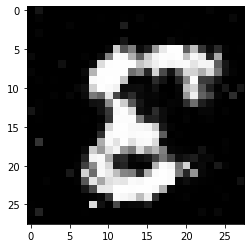

In [35]:
model_path = os.path.join(BINARIES_PATH, 'VANILLA_000010.pth')
assert os.path.exists(model_path), f'Could not find the model {model_path}. You first need to train your generator.'

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the model
model_state = torch.load(model_path)
print(f'Model states contains this data: {model_state.keys()}')

gan_type = model_state["gan_type"]
print(f"Using {gan_type} GAN!")

# Let's instantiate a generator net and place it on GPU
generator = GeneratorNet().to(device)
# Load its weights
generator.load_state_dict(model_state["state_dict"], strict=True)
generator.eval() # Puts some layers like batch-norm in a good state so its ready for inference

generated_imgs_path = os.path.join(DATA_DIR_PATH, 'generated_imagery')
os.makedirs(generated_imgs_path, exist_ok=True)

#
# This is where magic happens
#

print('Generating new MNIST-like images!')
generated_img = generate_from_random_latent_vector(generator)
save_and_maybe_display_image(generated_imgs_path, generated_img, should_display=True)